In [1]:
import gzip
import xml.etree.ElementTree as ET
import defusedxml.ElementTree as ET
import pandas as pd
from tqdm import tqdm
from collections import OrderedDict
import collections
from collections import Counter

import os
import pickle
import glob

In [2]:
os.chdir('/home/admin_user')

In [3]:
#MeSH 読込
with open('mesh_list_2021.pickle', 'rb') as f:
    mesh_list = pickle.load(f)

#メッシュから　メッシュIDと疾患/症状メッシュ、TreeNumber を取り出す
#疾患メッシュ：Cのうち C22（動物)とC23.888（症状）を除外したもの）＋F03（精神障害）
#症状メッシュ：C23.888
mesh_diseases = [descriptor for descriptor in tqdm(mesh_list) for uid in descriptor[-1] if ((uid.startswith("C")==True) & (uid.startswith("C22")!=True)&(uid.startswith("C23.888")!=True)) | (uid.startswith("F03")==True) ]
mesh_symptoms = [descriptor for descriptor in tqdm(mesh_list)  for uid in descriptor[-1] if (uid.startswith("C23.888")==True)]
#さらにメッシュ名だけにする＋重複削除
mesh_diseases= pd.DataFrame(mesh_diseases)[1].drop_duplicates(keep='last').reset_index(drop=True).values.tolist()
mesh_symptoms= pd.DataFrame(mesh_symptoms)[1].drop_duplicates(keep='last').reset_index(drop=True).values.tolist()

len(mesh_list),len(mesh_diseases), len(mesh_symptoms)

100%|██████████| 29917/29917 [00:00<00:00, 1690936.19it/s]


(29917, 4887, 394)

In [4]:
import glob
os.chdir('/home/admin_user/デスクトップ/pubmed_csv_from_xml')
csv_list = sorted(glob.glob('pubmed21n*.csv'))
len(csv_list)

1062

In [9]:
#disease抽出, csv作成(定義)

def select_decriptor_disease(df):

    if len(df)>0:
        
        for x in collist:
            df[x]=df[x].str.split('|')
            df[x]=df[x].fillna({i: [] for i in df.index}) 
            
        desc_set = [[pmid,
                     descs,
                     desc_majrs,
                     qual_majrs,
                     pubdate] for pmid, descs, desc_majrs, qual_majrs, pubdate in zip(df["PMID"],#0
                                                                                      df["Descriptor"],#1
                                                                                      df["Descriptor_MajorTopic"],#2
                                                                                      df["Qualifier_MajorTopic"],#3
                                                                                      df["PubMedPubDate"])]#-1    
        disease_list=[]
        symptom_list=[]
        for i in desc_set:
            for desc, desc_majr, qual_majr in zip(i[1], i[2], i[3]):
                if desc in mesh_diseases:
                    disease_list.append([i[0], desc, desc_majr, qual_majr, i[-1][0]])

                    
        disease_df = pd.DataFrame(disease_list, columns=["PMID", "disease", "desc_majr", "qual_majr", "pubdate"])
        disease_df["PubMedPubDate"] = pd.to_datetime(disease_df["pubdate"])
        del disease_df["pubdate"]
        
        #make csv
        os.chdir(path_2)
        disease_df.to_csv(file[:-4]+"_d.csv", index=False)
        os.chdir(path_1)
        
    else:
        disease_df = pd.DataFrame(columns=["PMID", "disease", "desc_majr", "qual_majr", "pubdate"])
        
        #make csv
        os.chdir(path_2)
        disease_df.to_csv(file[:-4]+"_d.csv", index=False)
        os.chdir(path_1)
                
    return

In [10]:
#disease抽出, csv作成(実行)

path_1 = '/home/admin_user/デスクトップ/pubmed_csv_from_xml'
path_2 = '/home/admin_user/デスクトップ/pubmed_d'

os.chdir(path_1)

collist = ["Descriptor", "Descriptor_MajorTopic","Qualifier_MajorTopic", "PubMedPubDate"]
csv_list = sorted(glob.glob('pubmed21n*.csv'))
for file in tqdm(csv_list):  
    df = pd.read_csv(file, engine='python')
    df = df[~df["Descriptor"].isna()]
    select_decriptor_disease(df)

100%|██████████| 1062/1062 [5:57:46<00:00, 20.21s/it] 


In [11]:
#csv読込、diseas_MeSHをさらにMajorTopicで絞り込む

os.chdir(path_2)

disease_df=pd.DataFrame()
csv_list = sorted(glob.glob('pubmed21n*_d.csv'))
for file in tqdm(csv_list):
    tmp_df = pd.read_csv(file, engine='python')
    tmp_df = tmp_df[ (tmp_df["desc_majr"]=="Y") | ( (tmp_df["desc_majr"]=="N") & (tmp_df["qual_majr"]=="Y") ) ]
    disease_df = pd.concat([disease_df, tmp_df])
disease_df = disease_df.reset_index(drop=True)
print(len(disease_df))

100%|██████████| 1062/1062 [08:45<00:00,  2.02it/s]


16251510


In [15]:
#symptom抽出, csv作成(定義)

def select_decriptor_symptom(df):

    if len(df)>0:
        
        for x in collist:
            df[x]=df[x].str.split('|')
            df[x]=df[x].fillna({i: [] for i in df.index}) 
            
        desc_set = [[pmid,
                     descs,
                     desc_majrs,
                     qual_majrs,
                     pubdate] for pmid, descs, desc_majrs, qual_majrs, pubdate in zip(df["PMID"],#0
                                                                                      df["Descriptor"],#1
                                                                                      df["Descriptor_MajorTopic"],#2
                                                                                      df["Qualifier_MajorTopic"],#3
                                                                                      df["PubMedPubDate"])]#-1    

        symptom_list=[]
        for i in desc_set:
            for desc, desc_majr, qual_majr in zip(i[1], i[2], i[3]):
                if desc in mesh_symptoms:
                    symptom_list.append([i[0], desc, i[-1][0]])
        
        symptom_df = pd.DataFrame(symptom_list, columns=["PMID", "symptom", "pubdate"])
        symptom_df["PubMedPubDate"] = pd.to_datetime(symptom_df["pubdate"])
        del symptom_df["pubdate"]    
        
        
        #make csv
        os.chdir(path_2)
        symptom_df.to_csv(file[:-4]+"_s.csv", index=False)        
        os.chdir(path_1)
        
    else:
        symptom_df = pd.DataFrame(columns=["PMID", "symptom", "PubMedPubDate"])
        
        #make csv
        os.chdir(path_2)
        symptom_df.to_csv(file[:-4]+"_s.csv", index=False)        
        os.chdir(path_1)
                
    return

In [21]:
#symptom抽出, csv作成(実行)

path_1 = '/home/admin_user/デスクトップ/pubmed_csv_from_xml'
path_2 = '/home/admin_user/デスクトップ/pubmed_s'

os.chdir(path_1)

collist = ["Descriptor", "Descriptor_MajorTopic","Qualifier_MajorTopic", "PubMedPubDate"]
csv_list = sorted(glob.glob('pubmed21n*.csv'))
for file in tqdm(csv_list):  
    df = pd.read_csv(file, engine='python')
    df = df[~df["Descriptor"].isna()]
    select_decriptor_symptom(df)

100%|██████████| 1062/1062 [35:20<00:00,  2.00s/it]


In [22]:
#symptom csv読込

os.chdir(path_2)
symptom_df=pd.DataFrame()
csv_list = sorted(glob.glob('pubmed21n*_s.csv'))
print(len(csv_list))

for file in tqdm(csv_list):
    tmp_df = pd.read_csv(file, engine='python')   
    symptom_df = pd.concat([symptom_df, tmp_df])
symptom_df = symptom_df.reset_index(drop=True)
print(len(symptom_df))

  1%|          | 8/1062 [00:00<00:13, 78.93it/s]

1062


100%|██████████| 1062/1062 [00:40<00:00, 26.16it/s]

2559584


In [29]:
del disease_df["pubdate"]

In [56]:
disease_df[ (disease_df["desc_majr"]=="N") & (disease_df["qual_majr"]=='N')]

,PMID,disease,desc_majr,qual_majr,PubMedPubDate


In [32]:
print(len(disease_df), len(symptom_df))

#使いたいメッシュを取り出せたのでcsv保存
os.chdir('/home/admin_user/デスクトップ/pubmed_descriptor')
disease_df.to_csv("disease_df.csv", index="False") 
symptom_df.to_csv("symptom_df.csv", index="False")

16251510 2559584


In [4]:

os.chdir('/home/admin_user/デスクトップ/pubmed_descriptor')
#2021MeSH disease, symptom
disease_df =pd.read_csv("disease_df.csv") 
symptom_df =pd.read_csv("symptom_df.csv")
print(len(disease_df), len(symptom_df))

16251510 2559584


In [5]:
#disease_df(Majrtopic OK)
#symptom_df

#MajorTopicは済んだので次に期間を絞り込む

#1966-new
disease_df_1966_new = disease_df[ (disease_df['PubMedPubDate']>="1966-01-01") ]
symptom_df_1966_new = symptom_df[ (symptom_df['PubMedPubDate']>="1966-01-01") ]

#ZHOU' 1966-2011
disease_df_zhou = disease_df[ (disease_df['PubMedPubDate']>="1966-01-01") & (disease_df["PubMedPubDate"]<"2011-11-01")]
symptom_df_zhou = symptom_df[ (symptom_df['PubMedPubDate']>="1966-01-01") & (symptom_df["PubMedPubDate"]<"2011-11-01")]


In [6]:
df_list = ["disease_df", "disease_df_1966_new", "disease_df_zhou",
           "symptom_df", "symptom_df_1966_new", "symptom_df_zhou"]

#文献数, pubmedpubdate
for i in df_list:
    print(i,  ":", eval(i)["PMID"].nunique(), eval(i)["PubMedPubDate"].min(), eval(i)["PubMedPubDate"].max())

disease_df : 10610024 1902-03-01 2020-12-01
disease_df_1966_new : 9450142 1966-01-01 2020-12-01
disease_df_zhou : 6563462 1966-01-01 2011-10-29
symptom_df : 2104427 1940-06-08 2020-11-29
symptom_df_1966_new : 1976103 1966-01-01 2020-11-29
symptom_df_zhou : 1389374 1966-01-01 2011-10-29


In [7]:
#mesh数
#disease
print("disease_MeSH: ", [ [ i, eval(i)["disease"].nunique()] for i in df_list[:3]])
#symptom
print("symptom_MeSH: ", [ [ i, eval(i)["symptom"].nunique()] for i in df_list[3:]])

disease_MeSH:  [['disease_df', 4822], ['disease_df_1966_new', 4820], ['disease_df_zhou', 4557]]
symptom_MeSH:  [['symptom_df', 385], ['symptom_df_1966_new', 384], ['symptom_df_zhou', 358]]


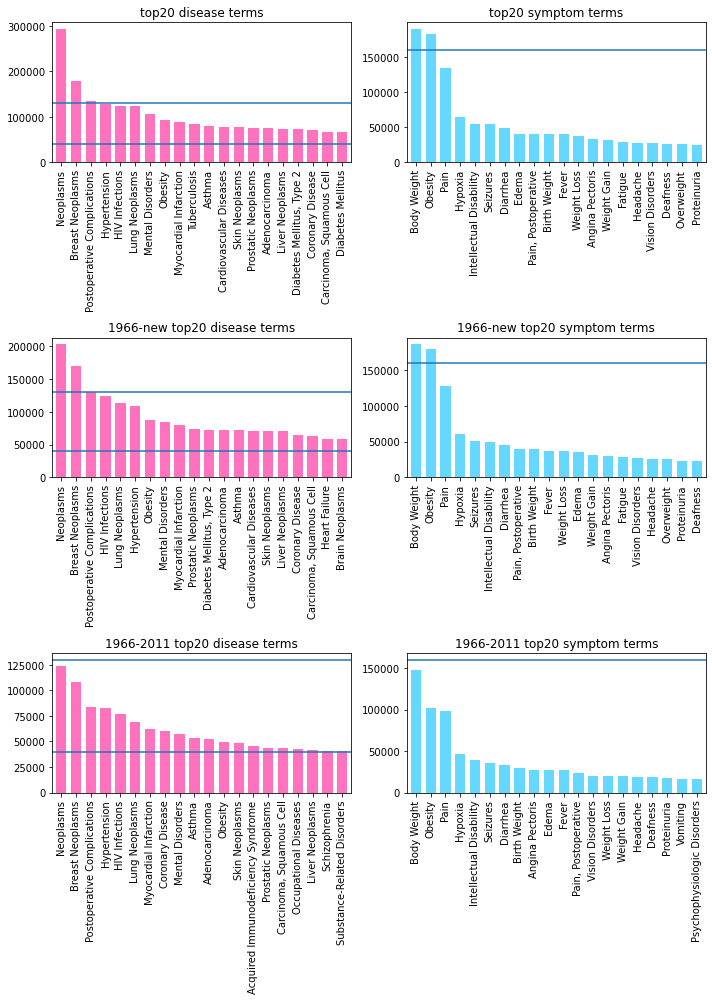

In [8]:
#共起ペアにする前の様子
#疾患メッシュ症状メッシュの出現数top20 

import matplotlib.pyplot as plt
plt.figure(figsize=(10,14))

#disease_df, symptom_df
plt.subplot(321)
disease_df["disease"].value_counts()[:20].plot.bar(width=0.7, alpha=0.6, color='DeepPink', title='top20 disease terms')#alpha=0.5
plt.axhline(y=40000)
plt.axhline(y=130000)
#plt.yticks([40000, 50000, 60000, 70000, 80000, 90000, 100000, 110000, 120000, 130000],[40, 50, 60, 70, 80, 90, 100, 110, 120 ,130])

plt.subplot(322)
symptom_df["symptom"].value_counts()[:20].plot.bar(width=0.7, alpha=0.6, color='DeepSkyBlue', title='top20 symptom terms')
plt.axhline(y=160000)
#plt.yticks([20000, 40000, 60000, 80000, 100000, 120000, 140000, 160000],[20, 40, 60, 80, 100, 120, 140, 160])

#disease_df_1966_new, limited_symptom_df
plt.subplot(323)
disease_df_1966_new["disease"].value_counts()[:20].plot.bar(width=0.7, alpha=0.6, color='DeepPink', title='1966-new top20 disease terms')
plt.axhline(y=40000)
plt.axhline(y=130000)

plt.subplot(324)
symptom_df_1966_new["symptom"].value_counts()[:20].plot.bar(width=0.7, alpha=0.6, color='DeepSkyBlue', title='1966-new top20 symptom terms')
plt.axhline(y=160000)


#Bdisease_df_zhou symptom_df_zhou
plt.subplot(325)
disease_df_zhou["disease"].value_counts()[:20].plot.bar(width=0.7, alpha=0.6, color='DeepPink', title='1966-2011 top20 disease terms')
plt.axhline(y=40000)
plt.axhline(y=130000)

plt.subplot(326)
symptom_df_zhou["symptom"].value_counts()[:20].plot.bar(width=0.7, alpha=0.6, color='DeepSkyBlue', title='1966-2011 top20 symptom terms')
plt.axhline(y=160000)


plt.tight_layout()
plt.show()


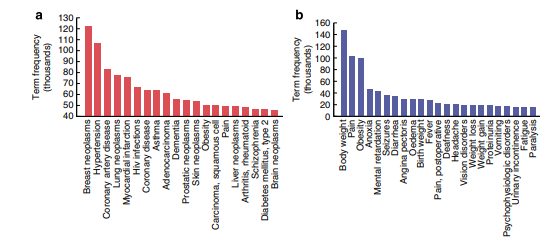

In [9]:
from IPython.display import Image
Image("/home/admin_user/キャプチャbarabasi.PNG")


In [10]:
#"disease_df", "symptom_df"

# disease|symptom どちらかを持つ文献数
print(len(sorted(list(set(disease_df["PMID"]) | set(symptom_df["PMID"])))))
print(pd.concat([disease_df, symptom_df])["PMID"].nunique())

# disease&symptom ペアを持つ文献数
print(len(sorted(list(set(disease_df["PMID"]) & set(symptom_df["PMID"])))))
print(pd.merge(disease_df, symptom_df, on=["PMID", "PubMedPubDate"])["PMID"].nunique())

11454761
11454761
1259690
1259690


In [11]:
#"disease_df_1966_new", "symptom_df_1966_new"

# disease|symptom どちらかを持つ文献数
print(len(sorted(list(set(disease_df_1966_new["PMID"]) | set(symptom_df_1966_new["PMID"])))))
print(pd.concat([disease_df_1966_new, symptom_df_1966_new])["PMID"].nunique())

# disease&symptom ペアを持つ文献数
print(len(sorted(list(set(disease_df_1966_new["PMID"]) & set(symptom_df_1966_new["PMID"])))))
print(pd.merge(disease_df_1966_new, symptom_df_1966_new, on=["PMID", "PubMedPubDate"])["PMID"].nunique())

10273718
10273718
1152527
1152527


In [12]:
#"disease_df_zhou", "symptom_df_zhou"

# disease|symptom どちらかを持つ文献数
print(len(sorted(list(set(disease_df_zhou["PMID"]) | set(symptom_df_zhou["PMID"])))))
print(pd.concat([disease_df_zhou, symptom_df_zhou])["PMID"].nunique())
# disease&symptom ペアを持つ文献数
print(len(sorted(list(set(disease_df_zhou["PMID"]) & set(symptom_df_zhou["PMID"])))))
print(pd.merge(disease_df_zhou, symptom_df_zhou, on=["PMID", "PubMedPubDate"])["PMID"].nunique())


7152977
7152977
799859
799859


#全文献数 31,850,055 
#xmlを読み込んだcsvからpmidの数を数える
each_csv_has_pmids=[]
for file in tqdm(csv_list[:]):
    tmp_df = pd.read_csv(file, engine='python', usecols=[0,6])#0=pmid, 6=Descriptor
    each_csv_has_pmids.append(len(tmp_df))
#31850055

In [ ]:
#####
#"disease_df", "symptom_df"
#"disease_df_1966_new", "symptom_df_1966_new"
#"disease_df_zhou", "symptom_df_zhou"

In [14]:
pmid_ds_pair_m2021 = pd.merge(disease_df, symptom_df, on=["PMID", "PubMedPubDate"])
pmid_ds_pair_m2021_1966_new = pd.merge(disease_df_1966_new, symptom_df_1966_new, on=["PMID", "PubMedPubDate"])
pmid_ds_pair_m2021_zhou = pd.merge(disease_df_zhou, symptom_df_zhou, on=["PMID", "PubMedPubDate"])
print(len(pmid_ds_pair_m2021), len(pmid_ds_pair_m2021_1966_new), len(pmid_ds_pair_m2021_zhou))

2631644 2276539 1561158


In [15]:
#疾患症状ペアデータ保存
os.chdir('/home/admin_user/デスクトップ/data')
pmid_ds_pair_m2021.to_csv("pmid_ds_pair_m2021.csv", index=False)
pmid_ds_pair_m2021_1966_new.to_csv("pmid_ds_pair_m2021_1966_new.csv", index=False)
pmid_ds_pair_m2021_zhou.to_csv("pmid_ds_pair_m2021_zhou.csv", index=False)

In [63]:
#疾患症状ペアの出現数の合計
print(len(pmid_ds_pair_m2021), len(pmid_ds_pair_m2021_1966_new), len(pmid_ds_pair_m2021_zhou))
#2631644 2276539 1561158

2631644 2276539 1561158


In [17]:
print("出現したds_pairペア数の合計, 種類数, disease_MeSHの種類数, symptom_MeSHの種類数")
for name, item in mydict.items():
    print(name, len(item), len(item[["disease", 'symptom']].value_counts()), item["disease"].nunique(), item["symptom"].nunique())

出現したds_pairペア数の合計, 種類数, disease_MeSHの種類数, symptom_MeSHの種類数
pmid_ds_pair_m2021 2631644 197466 4679 385
pmid_ds_pair_m2021_1966_new 2276539 182176 4662 384
pmid_ds_pair_m2021_zhou 1561158 145670 4304 357


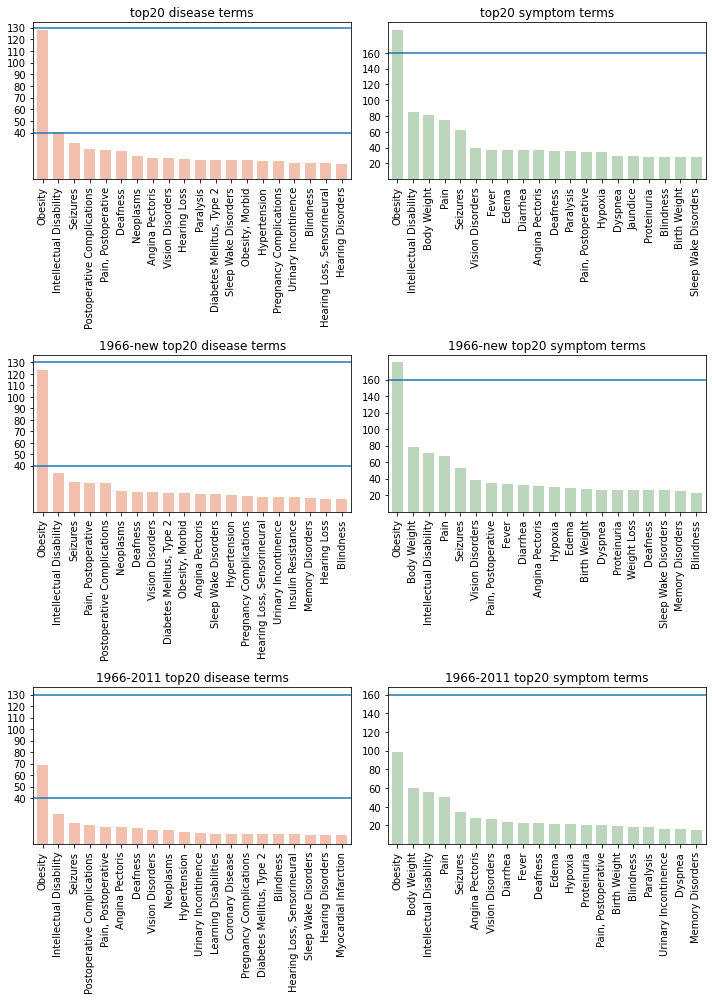

In [18]:
#疾患症状ペアの様子  DarkSalmon DarkSeaGreen
#疾患メッシュ症状メッシュの出現数top20

import matplotlib.pyplot as plt
plt.figure(figsize=(10,14))

#pmid_ds_pair_m2021
plt.subplot(321)
pmid_ds_pair_m2021["disease"].value_counts()[:20].plot.bar(width=0.7, alpha=0.6, color='DarkSalmon', title='top20 disease terms')#alpha=0.5
plt.axhline(y=40000)
plt.axhline(y=130000)
plt.yticks([40000, 50000, 60000, 70000, 80000, 90000, 100000, 110000, 120000, 130000],[40, 50, 60, 70, 80, 90, 100, 110, 120 ,130])

plt.subplot(322)
pmid_ds_pair_m2021["symptom"].value_counts()[:20].plot.bar(width=0.7, alpha=0.6, color='DarkSeaGreen', title='top20 symptom terms')
plt.axhline(y=160000)
plt.yticks([20000, 40000, 60000, 80000, 100000, 120000, 140000, 160000],[20, 40, 60, 80, 100, 120, 140, 160])

#pmid_ds_pair_m2021_1966_new
plt.subplot(323)
pmid_ds_pair_m2021_1966_new["disease"].value_counts()[:20].plot.bar(width=0.7, alpha=0.6, color='DarkSalmon', title='1966-new top20 disease terms')
plt.axhline(y=40000)
plt.axhline(y=130000)
plt.yticks([40000, 50000, 60000, 70000, 80000, 90000, 100000, 110000, 120000, 130000],[40, 50, 60, 70, 80, 90, 100, 110, 120 ,130])

plt.subplot(324)
pmid_ds_pair_m2021_1966_new["symptom"].value_counts()[:20].plot.bar(width=0.7, alpha=0.6, color='DarkSeaGreen', title='1966-new top20 symptom terms')
plt.axhline(y=160000)
plt.yticks([20000, 40000, 60000, 80000, 100000, 120000, 140000, 160000],[20, 40, 60, 80, 100, 120, 140, 160])

#pmid_ds_pair_m2021_zhou
plt.subplot(325)
pmid_ds_pair_m2021_zhou["disease"].value_counts()[:20].plot.bar(width=0.7, alpha=0.6, color='DarkSalmon', title='1966-2011 top20 disease terms')
plt.axhline(y=40000)
plt.axhline(y=130000)
plt.yticks([40000, 50000, 60000, 70000, 80000, 90000, 100000, 110000, 120000, 130000],[40, 50, 60, 70, 80, 90, 100, 110, 120 ,130])

plt.subplot(326)
pmid_ds_pair_m2021_zhou["symptom"].value_counts()[:20].plot.bar(width=0.7, alpha=0.6, color='DarkSeaGreen', title='1966-2011 top20 symptom terms')
plt.axhline(y=160000)
plt.yticks([20000, 40000, 60000, 80000, 100000, 120000, 140000, 160000],[20, 40, 60, 80, 100, 120, 140, 160])


plt.tight_layout()
plt.show()